# Convolutional neural network to reproduce the spectra

We will now do all of the analysis again with a new model. The assumption is that a Convolutional neural network can reproduce the data better.

What we will examine again
1.) Reproduce QCS
2.) Does the new model denoise better?
3.) Reproduce real data and do PCA

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

#importing the data
#gen = np.loadtxt("spectra_no_qcs.txt", delimiter=",")
gen = np.loadtxt("qcs_gen10000.txt", delimiter=",")
shp = gen.shape

#splitting data into train and test set, we only want 10 test spectra for the PCA
from sklearn.model_selection import train_test_split
train, test = train_test_split(gen, test_size=0.2, random_state=42, shuffle=True, stratify=None)

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler = StandardScaler()
test_scaled = standardscaler.fit_transform(test)
train = standardscaler.fit_transform(train)

#reshaping the data for the model
train = train.reshape(train.shape[0],train.shape[1],1) #(number of spectra, number of points per spectra, 1 extra dim)

train.shape[1],train.shape[2]

(1101, 1)

In [2]:
#https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression really nice documentation
#https://keras.io/examples/timeseries/timeseries_anomaly_detection/

model = keras.models.Sequential(name="autoencoder_conv1d")
model.add(layers.InputLayer(input_shape=(train.shape[1],train.shape[2])))
model.add(layers.Conv1D(64,7,activation='elu'))
model.add(layers.Conv1D(32,7,activation='elu'))
model.add(layers.Conv1DTranspose(64,7,activation='elu'))
model.add(layers.Conv1DTranspose(1,7,activation='elu')) 

print(model.summary())

Model: "autoencoder_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1095, 64)          512       
                                                                 
 conv1d_1 (Conv1D)           (None, 1089, 32)          14368     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1095, 64)         14400     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 1101, 1)          449       
 ranspose)                                                       
                                                                 
Total params: 29,729
Trainable params: 29,729
Non-trainable params: 0
_________________________________________________________________
None


In [3]:
model.compile(optimizer="adam", loss="mse")

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

results = model.fit(train, train, 
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[earlystopping, rl_on_plateau])

Epoch 1/10
57/57 [==============================] - 13s 221ms/step - loss: 0.1539 - val_loss: 0.1002 - lr: 0.0010
Epoch 2/10
57/57 [==============================] - 11s 192ms/step - loss: 0.1100 - val_loss: 0.0958 - lr: 0.0010
Epoch 3/10
57/57 [==============================] - 11s 189ms/step - loss: 0.1055 - val_loss: 0.0920 - lr: 0.0010
Epoch 4/10
57/57 [==============================] - 11s 192ms/step - loss: 0.0996 - val_loss: 0.0836 - lr: 0.0010
Epoch 5/10
57/57 [==============================] - 12s 214ms/step - loss: 0.0873 - val_loss: 0.0732 - lr: 0.0010
Epoch 6/10
57/57 [==============================] - 12s 214ms/step - loss: 0.0831 - val_loss: 0.0714 - lr: 0.0010
Epoch 7/10
57/57 [==============================] - 13s 222ms/step - loss: 0.0816 - val_loss: 0.0702 - lr: 0.0010
Epoch 8/10
57/57 [==============================] - 12s 216ms/step - loss: 0.0806 - val_loss: 0.0695 - lr: 0.0010
Epoch 9/10
57/57 [==============================] - 10s 172ms/step - loss: 0.0805 - val_

In [4]:
print(results.history)

{'loss': [0.15386566519737244, 0.11004991829395294, 0.10553936660289764, 0.09962526708841324, 0.08729477971792221, 0.08306600898504257, 0.08157078176736832, 0.08061930537223816, 0.08049170672893524, 0.0794643759727478], 'val_loss': [0.10017632693052292, 0.09580306708812714, 0.09195485711097717, 0.08361853659152985, 0.0732361376285553, 0.0714343935251236, 0.07018298655748367, 0.06948412209749222, 0.07004763931035995, 0.06842097640037537], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


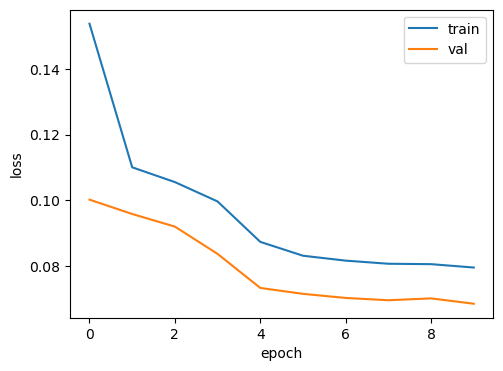

In [5]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [6]:
preds = model.predict(test_scaled, verbose=1)

63/63 [==============================] - 1s 15ms/step


In [7]:
preds_rescaled = standardscaler.inverse_transform(test_scaled)

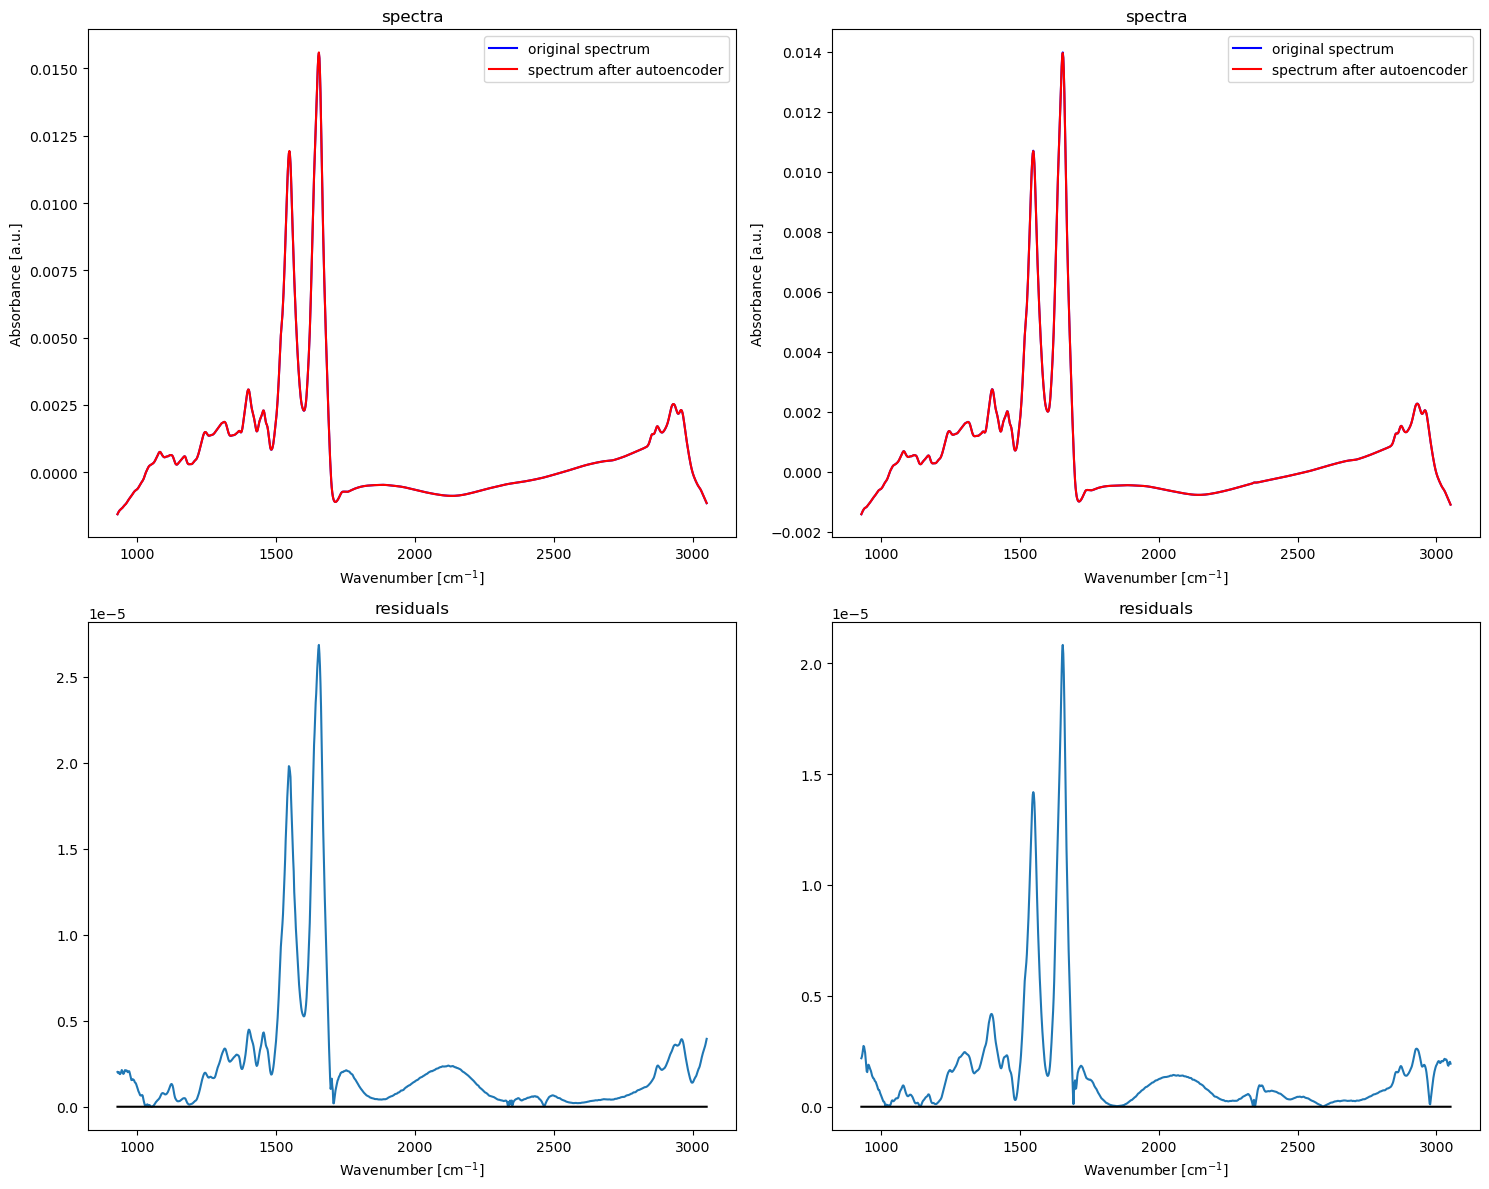

In [10]:
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', markersize= 0.5, label="original spectrum")
    ax1[i].plot(xaxis, preds_rescaled[idx[i]], 'r', markersize=0.5, label="spectrum after autoencoder")
    
    ax1[i].legend(loc=1)
    ax1[i].set_xlabel('Wavenumber [cm$^{-1}$]')
    ax2[i].set_xlabel('Wavenumber [cm$^{-1}$]')
    ax1[i].set_ylabel('Absorbance [a.u.]')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()